# A simple signal from BBO

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('binance-futures_book_ticker_2019-11-19_BTCUSDT.csv')
#df1 = pd.read_csv('binance-futures_book_ticker_2019-11-17_BTCUSDT.csv')
#df2 = pd.read_csv('binance-futures_book_ticker_2019-11-18_BTCUSDT.csv')
#df3 = pd.read_csv('binance-futures_book_ticker_2019-11-19_BTCUSDT.csv')
#df = pd.concat([df1, df2, df3], axis=0)
df = df.drop(columns = ['symbol', 'exchange', 'local_timestamp'])
df['spread'] = df['ask_price'] - df['bid_price']
df['RS'] = df['spread'] / (df['ask_price'] + df['bid_price']) * 2  #relative spread = spread / (mid price)

print(df)

                timestamp  ask_amount  ask_price  bid_price  bid_amount  \
0        1574121611312967       0.020    8183.77    8183.26       0.420   
1        1574121611316913       0.020    8183.77    8183.15       2.271   
2        1574121611724452       0.020    8183.77    8183.15       0.506   
3        1574121611724456       0.116    8183.75    8183.15       0.506   
4        1574121611724459       1.065    8183.26    8183.15       0.506   
...                   ...         ...        ...        ...         ...   
1141947  1574207993084505       2.279    8131.70    8131.06       0.687   
1141948  1574207993184902       0.100    8131.66    8131.06       0.687   
1141949  1574207993208979       0.020    8131.65    8131.06       0.687   
1141950  1574207996407574       2.227    8131.70    8131.06       0.687   
1141951  1574207997805966       0.023    8131.70    8131.06       0.687   

         spread        RS  
0          0.51  0.000062  
1          0.62  0.000076  
2          0.62

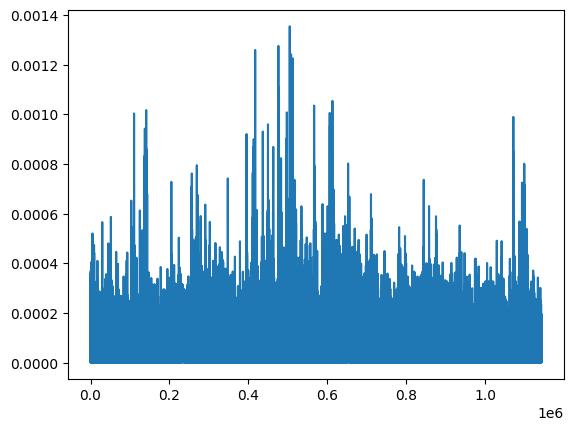

In [71]:
plt.plot(df['RS'])

**Basic Steps:** <br>
1.Monitor the spread if BBO, if the spread exceeds a threshold(set according to distribution, here it can be 0.001), generate the signal.<br>
2.For the signal, check the ask_price and bid_price. If the wide spread is because of the rising ask_price,  generate sell (short) signal. If the wide spread is because of the falling bid_price,  generate buy (long) signal.<br>
(I have checked some timestamps of large spread, and there is basically a rapid reversal trend afterward)<br>
3.Signal to close the position (Not decided yet, maybe when the spread come back to normal interval, or stop profit?)<br>

In [60]:
# Set threshold = 0.00030
threshold = 0.001
cash = 1000000
share = 0

df['signal'] = 0
long = 0
short = 0
amb = 0
for i in range(1, len(df)):
    if df['RS'][i] > threshold:
        bid_diff = df.loc[i, 'bid_price'] < df.loc[i-1, 'bid_price']
        ask_diff = df.loc[i, 'ask_price'] > df.loc[i-1, 'ask_price']
        
        if bid_diff and not ask_diff:
            df.loc[i, 'signal'] = -1
            short += 1
        elif ask_diff and not bid_diff:
            df.loc[i, 'signal'] = 1
            long += 1
        elif bid_diff and ask_diff:
            # If both conditions are true, cannot judge, just ignore it
            df.loc[i, 'signal'] = 99999  
            amb += 1



In [64]:
print(df.index[df['signal'] == 1].tolist())  #long signal
print(df.index[df['signal'] == -1].tolist())  #Short signal

[141043, 475747, 476902, 507874, 507889, 507890, 507892, 507894, 507898, 507902, 507907, 507909, 507914, 507915, 511842, 511857, 605781, 612658]
[110296, 417008, 475748, 475749, 475754, 497249, 504535, 504536, 507911, 566297]


**Potential implements/improvements:**<br>
1. Decide the signal to close the position<br>
2. Take the "ask_amount" and "bid_amount" into account. For example, calculate $\frac{ask\_amount}{(bid\_amount}$ to see the pressure ratio. This can also be a signal. Or use snapshot_5 or snapshot_25 to calculate the pressure ratio.
3. The data for a period of time is first divided into a training set, and statistics on whether the reversal trend of the training set is significant are used to justify the strategy. If the reversal trend is obvious then backtest the test set

**An example of reversal trend**
In this example below, the signal is generated in line 141043, where the ask_price just rised rapidly(8136 to 8143.07). Then we can notice that after this ask_price shows another rapid decline, which is a reversal of the trend. So we short the signal and close the position in time to make a profit

In [68]:
# An example of reversal trend
print(df[['ask_price', 'bid_price']].iloc[141040:141060])

        ask_price  bid_price
141040    8136.00    8134.79
141041    8136.00    8134.79
141042    8136.00    8134.79
141043    8143.07    8134.79
141044    8142.59    8134.79
141045    8137.42    8134.79
141046    8137.42    8135.56
141047    8137.42    8135.56
141048    8141.89    8135.56
141049    8139.92    8135.56
141050    8139.92    8135.56
141051    8141.89    8135.56
141052    8143.07    8135.56
141053    8141.88    8135.56
141054    8137.92    8135.56
141055    8136.00    8135.56
141056    8135.99    8135.56
141057    8141.88    8135.56
141058    8143.07    8141.90
141059    8143.07    8141.94
